# Single label Classifier - AF Detection

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
df_raw = pd.read_feather('tmp/pyhs-raw-corrected')
df_raw

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,mean_P_Onsets,mean_T_Offsets,HRV,label
0,64,1,8.203281,4460.777778,1.906904e+05,84.166667,77.666667,-32.750000,-46.666667,4017.0,...,8.233628e+06,3.074513e+10,0.326896,0.452789,-1.114599,-1.285166,4617.666667,5106.166667,300.261749,PAC
1,24,1,2.150430,9963.953488,1.612913e+05,183.904762,44.047619,-38.190476,-212.047619,9914.0,...,3.436726e+07,1.481045e+10,0.008229,-0.012282,-1.196234,-1.955239,10309.619048,10776.285714,252.051913,Normal
2,59,0,1.054852,7031.666667,2.289459e+05,120.466667,58.733333,-36.200000,-130.266667,6993.0,...,1.704473e+07,4.754209e+10,0.016040,0.102263,-1.178660,-1.859521,6736.266667,7255.600000,247.390310,PAC
3,14,1,7.645041,6695.090909,4.049139e+06,56.714286,57.190476,-148.619048,-121.952381,6660.0,...,1.752821e+07,8.191544e+11,0.031014,-4.325836,-1.220443,16.835113,6795.238095,7248.285714,319.844531,Normal
4,40,1,2.182612,5615.250000,1.302676e+06,196.000000,40.818182,-218.636364,-259.454545,5640.0,...,1.072786e+07,1.682837e+12,-0.014445,0.045967,-1.216803,-1.940233,5709.272727,6233.818182,237.254954,RBBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,61,1,2.200880,5355.391304,6.515502e+05,4.000000,4.600000,-13.800000,-558.100000,5212.0,...,8.467770e+06,5.689022e+11,-0.042738,0.273157,-1.121451,-1.911613,5066.800000,5409.800000,231.441628,AF
6873,78,1,4.201681,5052.095238,2.516323e+06,33.583333,-16.833333,-116.583333,-231.250000,4936.0,...,7.846417e+06,5.001414e+12,-0.059236,-0.246734,-0.964861,-1.885106,4722.000000,5218.000000,254.732016,AF
6874,12,1,1.583861,6097.157895,3.228570e+05,276.333333,30.777778,-94.222222,-266.166667,6134.0,...,1.271993e+07,5.643145e+10,-0.021902,0.088967,-1.201353,-1.860108,6067.111111,6543.000000,160.942494,Normal
6875,59,1,6.102441,5006.153846,7.516309e+05,-15.900000,13.333333,-36.500000,-34.700000,5632.0,...,9.243060e+06,3.005175e+11,-0.216776,-0.494394,-1.168932,-1.662923,NaN,5240.400000,413.754658,I-AVB


In [4]:
df_raw['PT_duration'] = df_raw['mean_T_Offsets'] - df_raw['mean_P_Onsets']

In [5]:
df_af = df_raw[(df_raw.loc[:, 'label'] == 'AF') | (df_raw.loc[:, 'label'] == 'Normal')]
df_af.reset_index(inplace=True)
df_af.drop(['index'], axis=1, inplace=True)
df_af

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,mean_P_Onsets,mean_T_Offsets,HRV,label,PT_duration
0,24,1,2.150430,9963.953488,1.612913e+05,183.904762,44.047619,-38.190476,-212.047619,9914.0,...,1.481045e+10,0.008229,-0.012282,-1.196234,-1.955239,10309.619048,10776.285714,252.051913,Normal,466.666667
1,14,1,7.645041,6695.090909,4.049139e+06,56.714286,57.190476,-148.619048,-121.952381,6660.0,...,8.191544e+11,0.031014,-4.325836,-1.220443,16.835113,6795.238095,7248.285714,319.844531,Normal,453.047619
2,56,0,17.006803,4754.846154,3.316727e+05,63.416667,0.250000,-13.333333,-157.833333,4879.0,...,1.307238e+11,0.022154,0.207103,-1.097015,-1.887570,4810.500000,5340.166667,205.366502,AF,529.666667
3,76,0,1.800720,4782.454545,1.049831e+05,60.785714,67.642857,-26.357143,-129.214286,4504.0,...,2.089867e+09,0.094930,0.002241,-1.298478,-0.886534,5261.142857,5768.571429,239.317084,AF,507.428571
4,80,1,0.785939,7077.642857,1.794358e+05,44.894737,31.736842,-20.894737,-174.315789,6764.0,...,1.425305e+10,0.118440,-0.645688,-1.106104,-1.408380,6326.210526,6885.894737,264.038788,AF,559.684211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,50,0,4.301721,4769.500000,4.155398e+05,45.000000,24.000000,-48.272727,-15.818182,4727.0,...,1.965987e+10,0.049527,-2.316869,-1.264079,4.716295,4988.727273,5444.000000,447.682314,Normal,455.272727
2135,61,1,2.200880,5355.391304,6.515502e+05,4.000000,4.600000,-13.800000,-558.100000,5212.0,...,5.689022e+11,-0.042738,0.273157,-1.121451,-1.911613,5066.800000,5409.800000,231.441628,AF,343.000000
2136,78,1,4.201681,5052.095238,2.516323e+06,33.583333,-16.833333,-116.583333,-231.250000,4936.0,...,5.001414e+12,-0.059236,-0.246734,-0.964861,-1.885106,4722.000000,5218.000000,254.732016,AF,496.000000
2137,12,1,1.583861,6097.157895,3.228570e+05,276.333333,30.777778,-94.222222,-266.166667,6134.0,...,5.643145e+10,-0.021902,0.088967,-1.201353,-1.860108,6067.111111,6543.000000,160.942494,Normal,475.888889


## Split between Train and Validation Datasets

In [6]:
def random_split(df, valid_size):
    np.random.seed(41)
    idxs_valid = np.random.permutation(len(df))[:valid_size]
    train = set(range(len(df)))
    valid = set(idxs_valid)
    idxs_train = list(train ^ valid)
    return df.iloc[idxs_valid].copy(), df.iloc[idxs_train].copy()

### Check to see if the dataset is balanced between AF and Normal

In [7]:
pd.get_dummies(df_af['label']).describe()

,AF,Normal
count,2139.000000,2139.000000
mean,0.570827,0.429173
std,0.495074,0.495074
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


### Split the dataset

In [7]:
valid_af, train_af = random_split(df_af, 600)  # One third
pd.get_dummies(train_af['label']).describe()

,AF,Normal
count,1539.000000,1539.000000
mean,0.560754,0.439246
std,0.496457,0.496457
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [9]:
pd.get_dummies(valid_af['label']).describe()

,AF,Normal
count,600.000000,600.000000
mean,0.596667,0.403333
std,0.490976,0.490976
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [8]:
df_train_af, y_train_af, nas = proc_df(train_af, 'label')

In [9]:
df_valid_af, y_valid_af, nas = proc_df(valid_af, 'label', na_dict=nas)

In [11]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(df_train_af, y_train_af)

m_af.score(df_train_af,y_train_af), m_af.score(df_valid_af, y_valid_af), m_af.oob_score_

CPU times: user 5.69 s, sys: 210 ms, total: 5.9 s
Wall time: 2.13 s


(1.0, 0.9366666666666666, 0.9324236517218973)

In [12]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

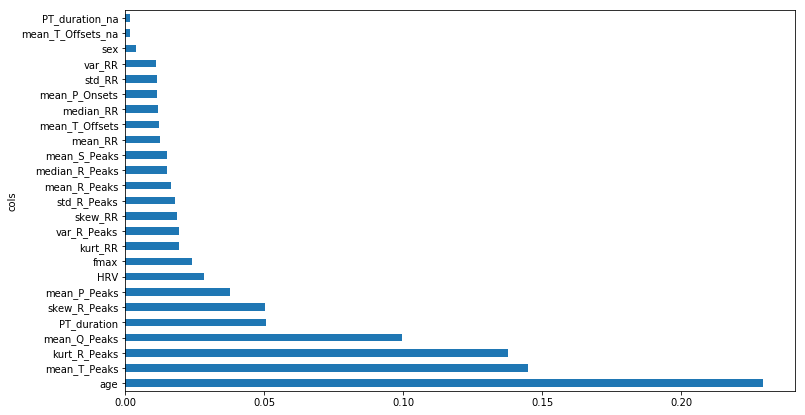

In [13]:
fi_af = rf_feat_importance(m_af, df_train_af)
plot_fi(fi_af[:25]);

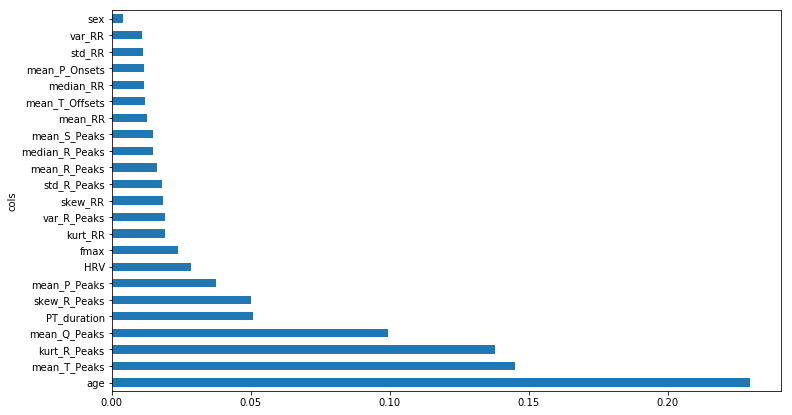

In [14]:
plot_fi(fi_af[fi_af['imp'] > 0.002]);

### Lets remove unimportant features to see if the model get more accurate

In [21]:
to_keep = list(fi_af[fi_af['imp'] > 0.002].cols)
to_keep.append('label')
df_keep = df_af[to_keep]

In [22]:
valid_af, train_af = random_split(df_keep, 600)  # One third
df_train_af, y_train_af, nas = proc_df(train_af, 'label')
df_valid_af, y_valid_af, nas = proc_df(valid_af, 'label', na_dict=nas)

In [26]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features=0.8, n_jobs=7, oob_score=True)

%time m_af.fit(df_train_af, y_train_af)

m_af.score(df_train_af,y_train_af), m_af.score(df_valid_af, y_valid_af), m_af.oob_score_

CPU times: user 16.4 s, sys: 104 ms, total: 16.5 s
Wall time: 3.24 s


(1.0, 0.94, 0.9324236517218973)

### Scaling Features

In [19]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(df_train_af)
X_valid = X_scaler.transform(df_valid_af)

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [20]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train_af)

m_af.score(X_train,y_train_af), m_af.score(X_valid, y_valid_af), m_af.oob_score_

CPU times: user 5.5 s, sys: 228 ms, total: 5.73 s
Wall time: 1.98 s


(1.0, 0.9333333333333333, 0.9285250162443145)